# Online Advertising Performance Analysis (Structured)

This notebook analyzes online advertising performance using your provided dataset (Apr-Jun 2020).
It is organized into clear sections with Markdown and Code cells.

**Dataset columns expected:** `month, day, campaign_number, user_engagement, banner, placement, displays, cost, clicks, revenue, post_click_conversions, post_click_sales_amount`

> If you move the CSV, update `DATA_PATH` in the **Setup & Load** section.


## 1. Setup & Load

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", 100)
pd.set_option("display.float_format", lambda x: f"{x:,.2f}")

# Path to your CSV (kept local to this notebook's folder by default)
DATA_PATH = "/content/online_advertising_performance_data.csv"

# Read & drop unnamed columns
df = pd.read_csv(DATA_PATH)
df = df.loc[:, ~df.columns.str.startswith("Unnamed")]
print("Raw rows:", len(df))
df.head()


Raw rows: 15408


,month,day,campaign_number,user_engagement,banner,placement,displays,cost,clicks,revenue,post_click_conversions,post_click_sales_amount
0,April,1,camp 1,High,160 x 600,abc,4,0.01,0,0.00,0,0.00
1,April,1,camp 1,High,160 x 600,def,20170,26.78,158,28.97,23,"1,972.46"
2,April,1,camp 1,High,160 x 600,ghi,14701,27.63,158,28.98,78,"2,497.26"
3,April,1,camp 1,High,160 x 600,mno,171259,216.88,1796,329.45,617,"24,625.32"
4,April,1,camp 1,Low,160 x 600,def,552,0.07,1,0.18,0,0.00


## 2. Schema Check & Basic Coercions

In [2]:

# Ensure expected columns exist
expected = {
    'month','day','campaign_number','user_engagement','banner','placement',
    'displays','cost','clicks','revenue','post_click_conversions','post_click_sales_amount'
}
missing = expected - set(df.columns)
if missing:
    raise ValueError(f"Missing columns in your CSV: {sorted(missing)}")

# Build a proper date column "Day" from month name + day (assume year 2020)
month_map = {
    'january':1,'february':2,'march':3,'april':4,'may':5,'june':6,
    'july':7,'august':8,'september':9,'october':10,'november':11,'december':12
}
df['month_num'] = df['month'].astype(str).str.strip().str.lower().map(month_map)
df['day'] = pd.to_numeric(df['day'], errors='coerce').astype('Int64')
df['Day'] = pd.to_datetime(dict(year=2020, month=df['month_num'], day=df['day']), errors='coerce')

# Coerce numeric columns
num_cols = ['displays','cost','clicks','revenue','post_click_conversions','post_click_sales_amount']
for c in num_cols:
    df[c] = pd.to_numeric(df[c], errors='coerce')

# Cleanup & types
df = df.dropna(subset=['Day']).copy()
df['clicks'] = df['clicks'].fillna(0).astype(int)
df['post_click_conversions'] = df['post_click_conversions'].fillna(0).astype(int)
df['displays'] = df['displays'].fillna(0).astype(int)
for c in ['cost','revenue','post_click_sales_amount']:
    df[c] = df[c].fillna(0.0).astype(float)

print("Rows after cleaning:", len(df))
df[['month','day','campaign_number','user_engagement','banner','placement','Day']].head()


Rows after cleaning: 15408


,month,day,campaign_number,user_engagement,banner,placement,Day
0,April,1,camp 1,High,160 x 600,abc,2020-04-01
1,April,1,camp 1,High,160 x 600,def,2020-04-01
2,April,1,camp 1,High,160 x 600,ghi,2020-04-01
3,April,1,camp 1,High,160 x 600,mno,2020-04-01
4,April,1,camp 1,Low,160 x 600,def,2020-04-01


## 3. Feature Engineering

In [3]:

# Derived metrics
df['CPC'] = np.where(df['clicks'] > 0, df['cost'] / df['clicks'], np.nan)
df['RPC'] = np.where(df['clicks'] > 0, df['revenue'] / df['clicks'], np.nan)
df['CR']  = np.where(df['clicks'] > 0, df['post_click_conversions'] / df['clicks'], np.nan)
df['AOV'] = np.where(df['post_click_conversions'] > 0, df['post_click_sales_amount'] / df['post_click_conversions'], np.nan)
df['ROI'] = np.where(df['cost'] > 0, (df['revenue'] - df['cost']) / df['cost'], np.nan)

# Calendar features
df['weekday'] = df['Day'].dt.day_name()
df['is_weekend'] = df['weekday'].isin(['Saturday', 'Sunday'])

df.describe(include='all')


,month,day,campaign_number,user_engagement,banner,placement,displays,cost,clicks,revenue,post_click_conversions,post_click_sales_amount,month_num,Day,CPC,RPC,CR,AOV,ROI,weekday,is_weekend
count,15408,"15,408.00",15408,15408,15408,14995,"15,408.00","15,408.00","15,408.00","15,408.00","15,408.00","15,408.00","15,408.00",15408,"10,513.00","10,513.00","10,513.00","5,570.00","15,344.00",15408,15408
unique,3,<NA>,3,3,8,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7,2
top,April,<NA>,camp 3,Medium,728 x 90,mno,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Wednesday,False
freq,6269,<NA>,6917,5489,3142,4501,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2233,11000
mean,NaN,15.52,NaN,NaN,NaN,NaN,"15,512.57",11.37,161.79,17.93,42.30,"2,123.29",4.88,2020-05-12 05:36:43.738317568,0.08,0.09,0.18,72.89,0.92,NaN,NaN
min,NaN,1.00,NaN,NaN,NaN,NaN,0.00,0.00,0.00,0.00,0.00,0.00,4.00,2020-04-01 00:00:00,0.00,0.00,0.00,1.09,-1.00,NaN,NaN
25%,NaN,8.00,NaN,NaN,NaN,NaN,78.00,0.02,0.00,0.00,0.00,0.00,4.00,2020-04-19 00:00:00,0.02,0.05,0.00,37.47,-1.00,NaN,NaN
50%,NaN,15.00,NaN,NaN,NaN,NaN,"1,182.00",0.34,6.00,0.48,0.00,0.00,5.00,2020-05-10 00:00:00,0.06,0.05,0.01,51.18,-0.15,NaN,NaN
75%,NaN,23.00,NaN,NaN,NaN,NaN,"8,960.25",2.54,53.00,3.84,3.00,163.35,6.00,2020-06-04 00:00:00,0.11,0.11,0.19,76.98,1.23,NaN,NaN
max,NaN,31.00,NaN,NaN,NaN,NaN,"455,986.00",556.70,"14,566.00","2,096.21","3,369.00","199,930.32",6.00,2020-06-30 00:00:00,1.24,0.20,16.00,"13,015.98",537.00,NaN,NaN


## 4. Q1: Trend in User Engagement

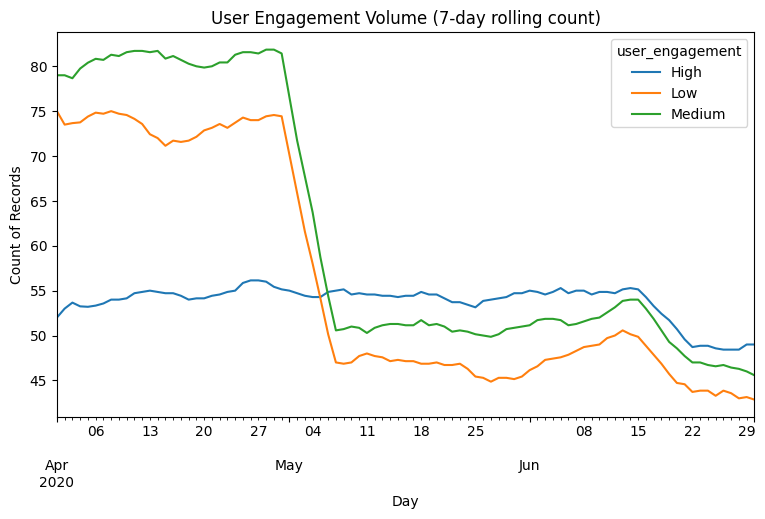

user_engagement,High,Low,Medium
Day,,,
2020-06-21,49,46,48
2020-06-22,49,43,48
2020-06-23,49,44,48
2020-06-24,48,43,44
2020-06-25,47,41,45
2020-06-26,48,45,46
2020-06-27,49,43,46
2020-06-28,49,42,47
2020-06-29,53,44,46


In [4]:

eng_trend = df.groupby(['Day','user_engagement']).size().unstack(fill_value=0)
eng_trend_rolling = eng_trend.rolling(7, min_periods=1).mean()
eng_trend_rolling.plot(figsize=(9,5), title='User Engagement Volume (7-day rolling count)')
plt.xlabel('Day'); plt.ylabel('Count of Records'); plt.show()
eng_trend.tail(10)


## 5. Q2: Banner Size Impact on Clicks

banner
240 x 400    1113256
728 x 90      569606
300 x 250     411214
160 x 600     239570
580 x 400     120681
670 x 90       37203
468 x 60        1295
800 x 250         12
Name: clicks, dtype: int64


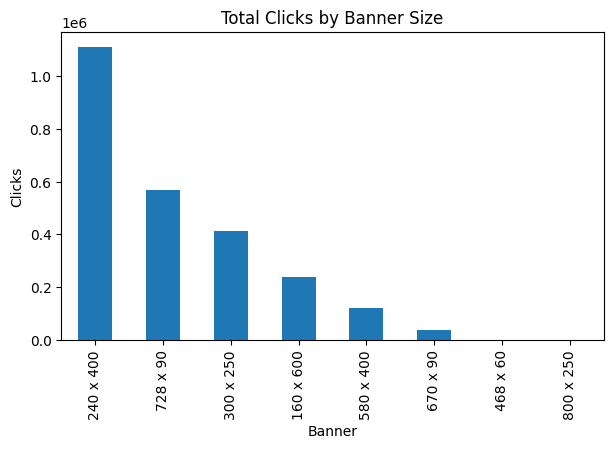

In [5]:

banner_clicks = df.groupby('banner')['clicks'].sum().sort_values(ascending=False)
print(banner_clicks)
banner_clicks.plot(kind='bar', figsize=(7,4), title='Total Clicks by Banner Size')
plt.xlabel('Banner'); plt.ylabel('Clicks'); plt.show()


## 6. Q3: Placements with Highest Displays & Clicks

In [6]:

place_perf = df.groupby('placement')[['displays','clicks']].sum().sort_values('displays', ascending=False)
place_perf.head(10)


,displays,clicks
placement,,
mno,143161775,993039
ghi,59740415,1247049
def,28177492,176097
jkl,7692732,75063
abc,242142,1584


## 7. Q4: Correlation Between Cost & Revenue

          cost  revenue  clicks  displays
cost      1.00     0.76    0.67      0.88
revenue   0.76     1.00    0.84      0.75
clicks    0.67     0.84    1.00      0.77
displays  0.88     0.75    0.77      1.00


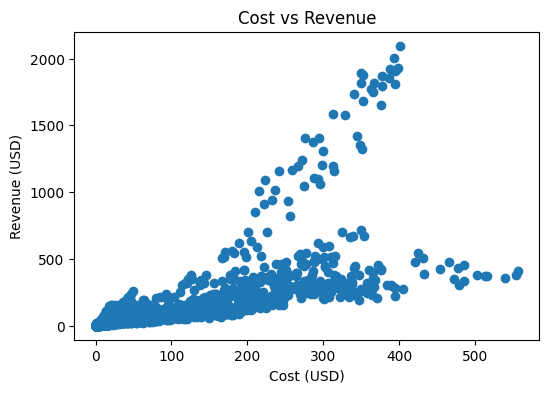

In [8]:

corr = df[['cost','revenue','clicks','displays']].corr()
print(corr)
plt.figure(figsize=(6,4))
plt.scatter(df['cost'], df['revenue'])
plt.title('Cost vs Revenue'); plt.xlabel('Cost (USD)'); plt.ylabel('Revenue (USD)'); plt.show()


## 8. Q5: Average Revenue per Click (RPC)

In [7]:

avg_rpc = df['RPC'].mean(skipna=True)
print(f"Average RPC: ${avg_rpc:0.2f}")


Average RPC: $0.09


## 9. Q6: Campaigns with Highest Conversion Rates (CR)

In [9]:

camp_cr = df.groupby('campaign_number').apply(
    lambda g: (g['post_click_conversions'].sum() / g['clicks'].sum()) if g['clicks'].sum() > 0 else np.nan
).sort_values(ascending=False)
camp_cr


/tmp/ipython-input-2980304743.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  camp_cr = df.groupby('campaign_number').apply(


,0
campaign_number,
camp 1,0.45
camp 3,0.02
camp 2,0.02


## 10. Q7: Post-Click Sales Amount Trend

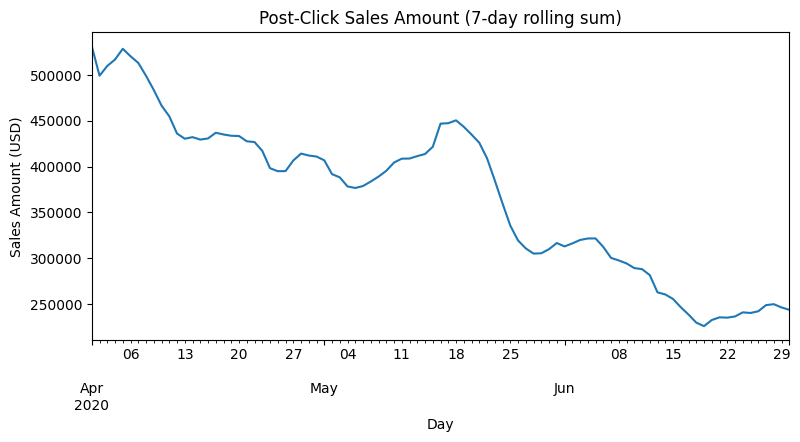

,post_click_sales_amount
Day,
2020-06-21,"268,579.05"
2020-06-22,"249,855.87"
2020-06-23,"266,515.13"
2020-06-24,"274,028.59"
2020-06-25,"177,379.89"
2020-06-26,"211,969.30"
2020-06-27,"294,567.51"
2020-06-28,"275,890.73"
2020-06-29,"225,088.42"


In [10]:

daily_sales = df.groupby('Day')['post_click_sales_amount'].sum()
daily_sales.rolling(7, min_periods=1).mean().plot(figsize=(9,4), title='Post-Click Sales Amount (7-day rolling sum)')
plt.xlabel('Day'); plt.ylabel('Sales Amount (USD)'); plt.show()
daily_sales.tail(10)


## 11. Q8: Engagement vs Banner Sizes

In [11]:

eng_banner = df.groupby(['banner','user_engagement'])[['clicks','post_click_conversions']].sum()
eng_banner['CR'] = np.where(eng_banner['clicks'] > 0, eng_banner['post_click_conversions'] / eng_banner['clicks'], np.nan)
eng_banner.sort_values('CR', ascending=False).head(10)


,,clicks,post_click_conversions,CR
banner,user_engagement,,,
468 x 60,High,534,519,0.97
800 x 250,High,4,3,0.75
580 x 400,High,47745,30275,0.63
300 x 250,High,199220,114430,0.57
728 x 90,High,315497,162741,0.52
670 x 90,High,19691,10111,0.51
160 x 600,High,97936,45881,0.47
240 x 400,High,636746,256962,0.40
468 x 60,Medium,676,28,0.04


## 12. Q9: Placement Conversion Rates

In [12]:

place_cr = df.groupby('placement').apply(
    lambda g: (g['post_click_conversions'].sum() / g['clicks'].sum()) if g['clicks'].sum() > 0 else np.nan
).sort_values(ascending=False)
place_cr


/tmp/ipython-input-262092755.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  place_cr = df.groupby('placement').apply(


,0
placement,
abc,0.52
jkl,0.28
ghi,0.27
mno,0.27
def,0.17


## 13. Q10: Weekday vs Weekend (Displays & Clicks)

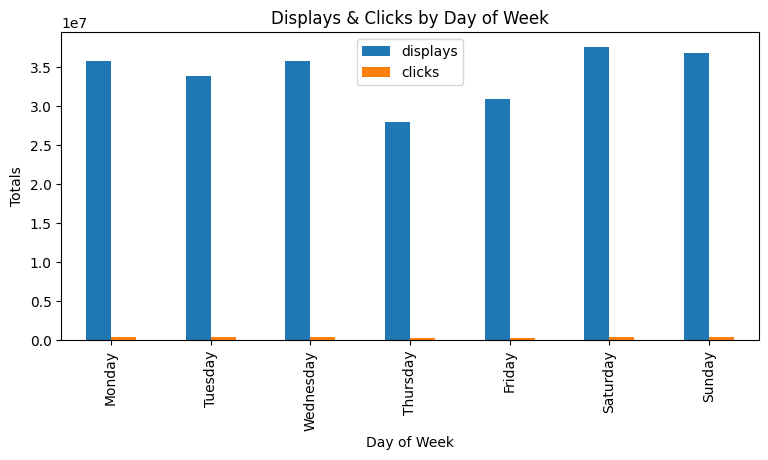

,displays,clicks
weekday,,
Monday,35827359,366054
Tuesday,33916870,360655
Wednesday,35793873,391409
Thursday,28053172,294218
Friday,30935919,308418
Saturday,37632529,389862
Sunday,36858003,382221


In [13]:

dow = df.groupby('weekday')[['displays','clicks']].sum().reindex(
    ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
)
dow.plot(kind='bar', figsize=(9,4), title='Displays & Clicks by Day of Week')
plt.xlabel('Day of Week'); plt.ylabel('Totals'); plt.show()
dow


## 14. Q11: Engagement Level & Revenue

In [14]:

eng_rev = df.groupby('user_engagement').agg(
    total_revenue=('revenue','sum'),
    total_clicks=('clicks','sum'),
    rpc=('RPC','mean'),
    cr=('CR','mean')
)
eng_rev['revenue_share'] = eng_rev['total_revenue'] / eng_rev['total_revenue'].sum()
eng_rev.sort_values('total_revenue', ascending=False)


,total_revenue,total_clicks,rpc,cr,revenue_share
user_engagement,,,,,
High,"212,263.88",1317373,0.10,0.43,0.77
Medium,"58,854.45",1073517,0.09,0.07,0.21
Low,"5,146.23",101947,0.09,0.05,0.02


## 15. Q12: Outliers in Cost, Clicks, Revenue

In [15]:

from scipy.stats import zscore
num_cols2 = ['cost','clicks','revenue']
z = df[num_cols2].apply(lambda s: (s - s.mean()) / s.std(ddof=0))
outliers = df[(z.abs() > 3).any(axis=1)][['Day','campaign_number','user_engagement','banner','placement'] + num_cols2]
print(f"Outlier rows: {len(outliers)}")
outliers.head(20)


Outlier rows: 481


,Day,campaign_number,user_engagement,banner,placement,cost,clicks,revenue
3,2020-04-01,camp 1,High,160 x 600,mno,216.88,1796,329.45
11,2020-04-01,camp 1,High,240 x 400,ghi,351.92,10237,"1,877.82"
13,2020-04-01,camp 1,High,240 x 400,mno,432.59,2120,388.82
26,2020-04-01,camp 1,High,300 x 250,mno,336.11,2042,374.53
61,2020-04-01,camp 1,High,728 x 90,ghi,292.80,3384,620.75
63,2020-04-01,camp 1,High,728 x 90,mno,424.07,2961,543.14
81,2020-04-01,camp 2,Medium,160 x 600,mno,45.95,3611,141.95
87,2020-04-01,camp 2,Medium,240 x 400,ghi,184.08,10390,408.42
89,2020-04-01,camp 2,Medium,240 x 400,mno,61.66,2720,106.91
99,2020-04-01,camp 2,Medium,300 x 250,mno,73.52,3328,130.82


## 16. Q13: Effectiveness by Banner & Placement (ROI, CR)

In [16]:

eff = df.groupby(['banner','placement']).agg(
    cost=('cost','sum'),
    revenue=('revenue','sum'),
    clicks=('clicks','sum'),
    conversions=('post_click_conversions','sum')
)
eff['ROI'] = np.where(eff['cost'] > 0, (eff['revenue'] - eff['cost']) / eff['cost'], np.nan)
eff['CR'] = np.where(eff['clicks'] > 0, eff['conversions'] / eff['clicks'], np.nan)
eff.sort_values('ROI', ascending=False).head(15)


,,cost,revenue,clicks,conversions,ROI,CR
banner,placement,,,,,,
240 x 400,ghi,"31,468.61","103,894.56",866275,210014,2.30,0.24
300 x 250,ghi,"4,227.58","12,609.79",117586,26609,1.98,0.23
240 x 400,jkl,"2,330.03","5,719.27",52580,13978,1.45,0.27
728 x 90,jkl,963.68,"2,172.15",19160,5854,1.25,0.31
670 x 90,jkl,30.68,45.38,781,143,0.48,0.18
160 x 600,mno,"14,314.19","20,201.37",209511,42239,0.41,0.20
728 x 90,ghi,"23,552.23","32,186.55",241767,92077,0.37,0.38
240 x 400,def,"2,985.59","4,009.42",48452,5376,0.34,0.11
160 x 600,def,"1,455.23","1,939.99",20257,2525,0.33,0.12


## 17. Q14: Consistent Outperformers (Campaign × Banner)

In [17]:

group = df.groupby(['campaign_number','banner']).agg(
    roi_mean=('ROI','mean'),
    roi_std=('ROI','std'),
    n=('ROI','count')
)
group = group[group['n'] >= 10].sort_values('roi_mean', ascending=False)
group.head(20)


roi_mean  roi_std     n
campaign_number banner                            
camp 3          160 x 600      3.10    23.75   784
camp 1          160 x 600      2.93    27.66   799
camp 2          580 x 400      2.11     0.53    60
camp 3          580 x 400      2.00     1.92   273
camp 1          240 x 400      1.53     2.28  1092
                300 x 250      1.17     4.04  1257
                580 x 400      1.07     1.69   273
camp 2          240 x 400      0.91     0.75   240
                670 x 90       0.85     1.99   240
camp 3          670 x 90       0.80     4.08  1057
camp 1          468 x 60       0.69    15.32   876
                670 x 90       0.67     4.27  1055
camp 2          300 x 250      0.66     1.74   283
camp 1          728 x 90       0.66     2.58  1381
camp 3          300 x 250      0.53     1.88  1280
camp 2          160 x 600      0.51     1.23   215
camp 3          468 x 60       0.47     6.65   809
camp 2          728 x 90       0.27     1.00   320
camp 3          240 x 400      0.22     1.05  1093
                728 x 90       0.13     1.86  1441

## 18. Q15: Conversions by Placement

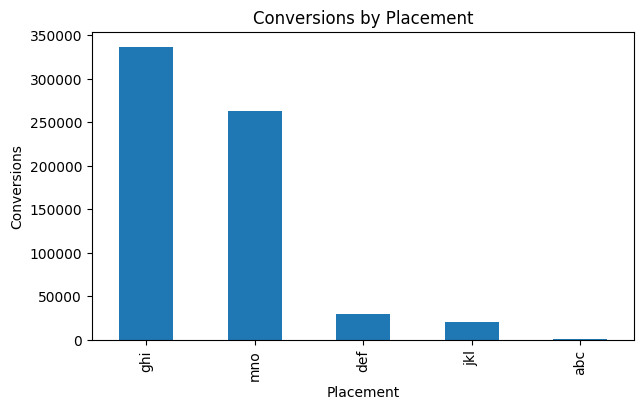

,post_click_conversions
placement,
ghi,337063
mno,263170
def,29856
jkl,20853
abc,824


In [18]:

conv_dist = df.groupby('placement')['post_click_conversions'].sum().sort_values(ascending=False)
conv_dist.plot(kind='bar', figsize=(7,4), title='Conversions by Placement')
plt.xlabel('Placement'); plt.ylabel('Conversions'); plt.show()
conv_dist


## 19. Q16: Engagement on Weekdays vs Weekends

In [19]:

ew = df.groupby(['is_weekend','user_engagement'])['clicks'].sum().unstack(fill_value=0)
ew


user_engagement,High,Low,Medium
is_weekend,,,
False,900434,70633,749687
True,416939,31314,323830


## 20. Q17: CPC Across Campaigns & Banners

In [20]:

cpc_viz = df.groupby(['campaign_number','banner'])['CPC'].mean().unstack()
cpc_viz


banner,160 x 600,240 x 400,300 x 250,468 x 60,580 x 400,670 x 90,728 x 90,800 x 250
campaign_number,,,,,,,,
camp 1,0.13,0.09,0.11,0.22,0.10,0.13,0.10,0.03
camp 2,0.04,0.02,0.03,0.03,0.01,0.03,0.03,0.01
camp 3,0.05,0.08,0.05,0.01,0.04,0.05,0.09,0.00


## 21. Q18: Cost per Conversion (Lower is Better)

In [21]:

df['CostPerConversion'] = np.where(df['post_click_conversions'] > 0, df['cost'] / df['post_click_conversions'], np.nan)
cpcv = df.groupby(['campaign_number','placement'])['CostPerConversion'].mean().sort_values()
cpcv.head(20)


campaign_number  placement
camp 1           abc         0.16
                 jkl         0.26
camp 3           abc         0.32
camp 1           ghi         0.33
                 mno         0.47
                 def         0.58
camp 3           def         0.87
                 jkl         0.98
camp 2           jkl         1.14
                 mno         1.55
camp 3           ghi         1.59
camp 2           def         1.60
                 ghi         1.65
camp 3           mno         1.76
camp 2           abc          NaN
Name: CostPerConversion, dtype: float64

## 22. Q19: Conversion Rate by Day of Week

/tmp/ipython-input-3995534812.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  dow_cr = df.groupby('weekday').apply(


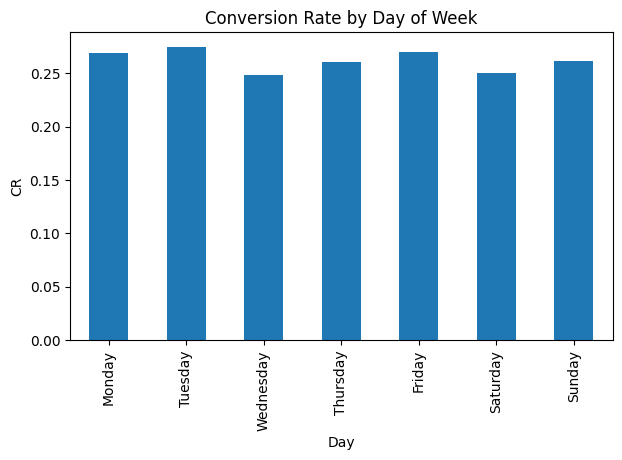

,0
weekday,
Monday,0.27
Tuesday,0.27
Wednesday,0.25
Thursday,0.26
Friday,0.27
Saturday,0.25
Sunday,0.26


In [22]:

dow_cr = df.groupby('weekday').apply(
    lambda g: (g['post_click_conversions'].sum() / g['clicks'].sum()) if g['clicks'].sum() > 0 else np.nan
).reindex(['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
dow_cr.plot(kind='bar', figsize=(7,4), title='Conversion Rate by Day of Week')
plt.xlabel('Day'); plt.ylabel('CR'); plt.show()
dow_cr


## 23. Q20: Effectiveness Across Engagement Types

In [23]:

eng_eff = df.groupby('user_engagement').agg(
    clicks=('clicks','sum'),
    conversions=('post_click_conversions','sum')
)
eng_eff['cr'] = np.where(eng_eff['clicks'] > 0, eng_eff['conversions'] / eng_eff['clicks'], np.nan)
eng_eff = eng_eff.sort_values('cr', ascending=False)
eng_eff


,clicks,conversions,cr
user_engagement,,,
High,1317373,620922,0.47
Medium,1073517,29257,0.03
Low,101947,1589,0.02


## 24. Summary KPIs

In [24]:

summary = {
    'Total Displays': int(df['displays'].sum()),
    'Total Clicks': int(df['clicks'].sum()),
    'Total Cost ($)': float(df['cost'].sum()),
    'Total Revenue ($)': float(df['revenue'].sum()),
    'Total Conversions': int(df['post_click_conversions'].sum()),
    'Avg CPC ($)': float(df['CPC'].mean(skipna=True)),
    'Avg RPC ($)': float(df['RPC'].mean(skipna=True)),
    'Overall CR': float(df['post_click_conversions'].sum()/df['clicks'].sum()) if df['clicks'].sum() > 0 else np.nan,
    'Overall ROI': float((df['revenue'].sum() - df['cost'].sum())/df['cost'].sum()) if df['cost'].sum() > 0 else np.nan
}
summary


{'Total Displays': 239017725,
 'Total Clicks': 2492837,
 'Total Cost ($)': 175192.9957,
 'Total Revenue ($)': 276264.5621,
 'Total Conversions': 651768,
 'Avg CPC ($)': 0.08167865449119809,
 'Avg RPC ($)': 0.09292719134276431,
 'Overall CR': 0.2614563246614199,
 'Overall ROI': 0.5769155667220547}